In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

<h1>Community detection</h1>
Communities are structures within networks where the links within a community are denser than the links out of the community. The problem of community detection is of particular interest because they often correspond to structurally interesting properties of the network, e.g. factions in social networks, similar functional groups in metabolic networks

<h2>Examples</h2>
<h3>Political books purchased on Amazon</h3>
<img src="files/political_books.png"> 
<!-- If the images are not showing up, use this instead: <img src="political_books.png"> -->
(Newman 2003) Applying community detection algorithms to the co-purchasing network of political books on Amazon divides the network into two groups that nearly exactly reproduce the political affiliations of the authors.

<h3>Karate Network</h3>
<img src="files/karate.png">
<!-- If the images are not showing up, use this instead: <img src="karate.png"> -->
(Zachary 1977) A karate club split into two factions after a conflict between members. This graph is often used as a benchmark test for community detection algorithms; we will use it in the following examples.

<h3>Dolphin Network</h3>
<img src="files/dolphins.png">
<!-- If the images are not showing up, use this instead: <img src="dolphins.png"> -->
(Lusseau, et al. 2003) A similar division happened in a dolphin social network, after one member of the group left, the dolphin community separated into two separate, non-interacting pods.

<h1>Example network: Karate Club</h1>

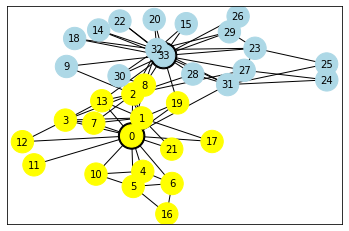

In [2]:
karate = nx.karate_club_graph()
#Coloring factions
(faction1_col, faction2_col) = ('yellow','lightblue')
#Building list of colors
node_color = [''] * len(karate.nodes())
node_dict = dict(karate.nodes(data=True))
#Assign colors based on factions
for n in karate.nodes():
    if node_dict[n]['club'] == 'Mr. Hi':
        node_color[n] = faction1_col
    elif node_dict[n]['club'] == 'Officer':
        node_color[n] = faction2_col
    else:
        print("Something is broken")
        break;
# Initialize the position
pos = nx.spring_layout(karate,scale=0.2)
# Label nodes
nx.draw_networkx_labels(karate,pos,font_size=10,font_color='black')
# Highlight the leaders
nx.draw_networkx_nodes(karate,pos,{0,33},node_color=['black','black'],node_size=700)
# Now draw all the nodes, including leaders, using faction color scheme.
nx.draw_networkx_nodes(karate,pos,node_color=node_color,node_size=500)
nx.draw_networkx_edges(karate,pos)
plt.show()

<h1>Algorithms</h1>

<h2>Algorithm: $k$-clique-community detection</h2>
$k$-clique detection finds communities of cliques of minimum degree $k$ that share at least $k-1$ nodes. The algorithm uses a percolation method to find these communities: a $k$-clique topological "template" is fitted over a clique, and one node of the clique is switched with another connected node outside of the clique. If this group of nodes is also a clique, that node is added to the $k$-clique-community. This is repeated until all cliques are visited.

In [3]:
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import quality

In [4]:
c = list(k_clique_communities(karate,3))
pp.pprint(c)

[   frozenset({   0,
                  1,
                  2,
                  3,
                  7,
                  8,
                  12,
                  13,
                  14,
                  15,
                  17,
                  18,
                  19,
                  20,
                  21,
                  22,
                  23,
                  26,
                  27,
                  28,
                  29,
                  30,
                  31,
                  32,
                  33}),
    frozenset({0, 4, 5, 6, 10, 16}),
    frozenset({24, 25, 31})]


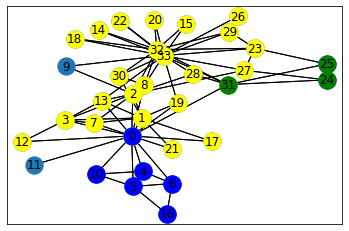

In [5]:
nx.draw_networkx(karate,pos)
nx.draw_networkx_nodes(karate,pos,nodelist=c[0],node_color=['yellow'])
nx.draw_networkx_nodes(karate,pos,nodelist=c[1],node_color=['blue'])
nx.draw_networkx_nodes(karate,pos,nodelist=c[2],node_color=['green'])
nx.draw_networkx_edges(karate,pos)
plt.show()

<h2>Algorithm: Girvan-Newman</h2>
This method finds communities by iteratively removing edges with maximum betweenness centrality, recalculating centrality for the affected nodes, then removing the max-betweenness edge, etc. 

Betweenness centrality for edge $e$ is calculated as:
\begin{align}
g(e) = \sum_{s \neq t} \frac{\sigma_{st}(e)}{\sigma_{st}}
\end{align}
where $s,t$ are the starting and terminal nodes, and $\sigma_{st}$ is the number of shortest paths from $s\rightarrow t$, and $\sigma_{st}(e)$ is the number of those shortest paths that contain edge $e$

Determining when to stop removing edges is a free parameter in the algorithm. Typical choices include: reaching a predefined number of separate remaining subgraphs or maximization of modularity (discussed later). 

In [6]:
from networkx.algorithms.community.centrality import girvan_newman
import itertools

In [7]:
c = list(girvan_newman(karate))
#pp.pprint(c)
k = 6 ### maximun number of clusters 
divisions =0;
comp = girvan_newman(karate)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    divisions+=1
    print((tuple(sorted(c) for c in communities)))
    
    
print('Number of hierarchies:',divisions)
print('Selecting',k,'clusters:',c[divisions-1])
print('Modularity ', quality.modularity(karate,c[divisions-1]))
print('First division: ',c[0])
print('Modularity ', quality.modularity(karate,c[0]))
print('Second Division: ',c[1])
print('Modularity ', quality.modularity(karate,c[1]))

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [9])
([0, 1, 3, 7, 11, 12, 13, 17, 19, 21], [2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [4, 5, 6, 10, 16], [9])
([0, 1, 3, 7, 11, 12, 13, 17, 19, 21], [2, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16], [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33], [9])
([0, 1, 3, 7, 12, 13, 17, 19, 21], [2, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16], [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33], [9], [11])
Number of hierarchies: 5
Selecting 6 clusters: ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11})
Modularity  0.3925049309664695
First division:  ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 2

In [8]:
## Let's draw the second Division which has 3 clusters
cd = list(c[0])  

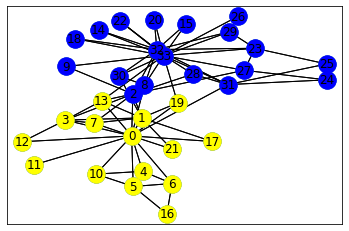

In [9]:
nx.draw_networkx(karate,pos)
nx.draw_networkx_nodes(karate,pos,nodelist=cd[0],node_color=['yellow'])
nx.draw_networkx_nodes(karate,pos,nodelist=cd[1],node_color=['blue'])
#nx.draw_networkx_nodes(karate,pos,nodelist=cd[2],node_color=['green'])
nx.draw_networkx_edges(karate,pos)
plt.show()

<h2>Metric: Modularity</h2>
Modularity is a network metric that measures how much community structure a network has. The modularity of a network calculated against a null random graph generated via the configuration model. The configuration model takes a prescribed degree distribution but has a random rewiring of edges. One can view the null configuration model graph as cutting all the edges of the original graph, but preserving the "stubs" on the vertices, and randomly rewiring all the stubs.

The modularity of a graph with $c$ communities is then calculated as:
\begin{align}
Q = \frac{1}{2m} \sum_{vw} \big[\frac{A_{vw}}{2m} - \frac{k_v k_w}{(2m)^2}\big]\delta(c_v, c_w)
\end{align}
where $m$ is the total number of edges, $v,w$ are nodes in the graph, $A_{vw}$ is the actual number of edges between $v$ and $w$, $k_v$ is the degree of the node, and $\delta$ is the dirac delta function.

The modularity thus measures how much more within-community connectivity we observe in the network over the null model (where connectivity is proportional simply to the degree of the node). By choosing which communities the vertices belong to, we can try to maximize $Q$.

<h2>Algorithm: Modularity Maximization via spectral methods</h2>
(Newman 2006) shows that the eigenvector corresponding to the least-negative eigenvalue of the modularity matrix with elements $B_{vw} = A_{vw} - \frac{k_v k_w}{2m}$ can be used to partition the network into two communities that maximizes modularity. The process can be repeated on each subgraph to further divide the group into more communities.

The leading eigenvector $V$ has length equal to the number of nodes in the network. Based on the sign of the $i^{th}$ element of $V$, node $i$ is assigned to group 1 if it's positive and 2 if it's negative.


<h2>Algorithm: Modularity Maximization Heuristics</h2>
(Louvain 2008) offers a percolation-inspired heuristic for community detection. The algorithm has two phases that are applied iteratively: the first phase is a greedy algorithm that places all nodes in their own community, then each node is moved to the community that gives the maximum gain in modularity. This is repeated for all nodes until no more modularity improvement can be made.

The second phase builds a new graph where the communities from phase 1 are collapsed into a single node, and the edges between communities collapse into single edges between the respective nodes with equivalent weight. Then phase 1 is repeated on this reduced graph, and the passes continue until no changes occur over a pass.

In [10]:
! pip install python-louvain

     |████████████████████████████████| 204 kB 8.1 MB/s eta 0:00:01
  Created wheel for python-louvain: filename=python_louvain-0.15-py3-none-any.whl size=9400 sha256=9389a2929265dc23192993c9fbb45e84204f8d7f5aceb6e64c3af2cbb72bee28
  Stored in directory: /Users/alben/Library/Caches/pip/wheels/c7/4c/ef/427db8777620f7fa12a6404f1527a39536a812f46a4d1044d3
Successfully built python-louvain


In [11]:
import community as community_louvain
import community 
from community import community_louvain

In [12]:
partition = community_louvain.best_partition(karate)
cc=[]

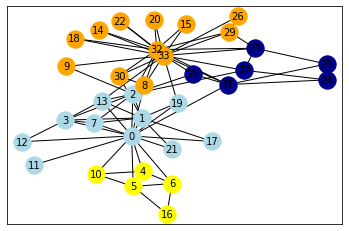

In [13]:
#drawing
size = float(len(set(partition.values())))
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    cc.append(list_nodes)
    
    
#Needs to know the number of partitions
#nx.draw_networkx(karate,pos)
#nx.draw_networkx_nodes(karate,pos,node_color=node_color)
nx.draw_networkx_nodes(karate,pos,nodelist=cc[0],node_color=['lightblue'])
nx.draw_networkx_nodes(karate,pos,nodelist=cc[2],node_color=['yellow'])
nx.draw_networkx_nodes(karate,pos,nodelist=cc[1],node_color=['darkblue'])
nx.draw_networkx_nodes(karate,pos,nodelist=cc[3],node_color=['orange'])
nx.draw_networkx_edges(karate,pos)
# Label nodes
nx.draw_networkx_labels(karate,pos,font_size=10,font_color='black')
plt.show()

In [14]:
community_louvain.modularity(partition,karate)

0.41978961209730437

# Calculate communities from larger datasets

In [15]:
nodes = np.loadtxt("THE_NODES.txt",dtype=[('f0', '|S5'), ('f1', int),('f2', float), ('f3', float),('f4',int)],usecols=(0,1,2,3,4))
links = np.loadtxt("THE_LINKS.txt",dtype=[('f0', '|S5'), ('f1', '|S5'),('f2', float), ('f3', int)],usecols=(0,1,2,3))


In [16]:
# build commuter flow network
g = nx.Graph()
for row in links:
    g.add_edge(row[0],row[1],weight=row[3])
    
# a) How many nodes and links are there?
print(nx.number_of_nodes(g))
print(nx.number_of_edges(g))

3141
130909


In [17]:
poss = {}
for row in nodes:
    #print node
    node=row[0]
    lat=row[2]
    lon=row[3]
    poss[node] = (lon,lat)

In [18]:
#first compute the best partition
partition = community_louvain.best_partition(g)

In [19]:
CC=[]
#drawing
size = float(len(set(partition.values())))
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    CC.append(list_nodes)

In [20]:
count

108.0

In [21]:
community_louvain.modularity(partition,g)

0.9649734340690087

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-177.69931245, -62.30514455000001, 17.1381038, 73.14529019999999)

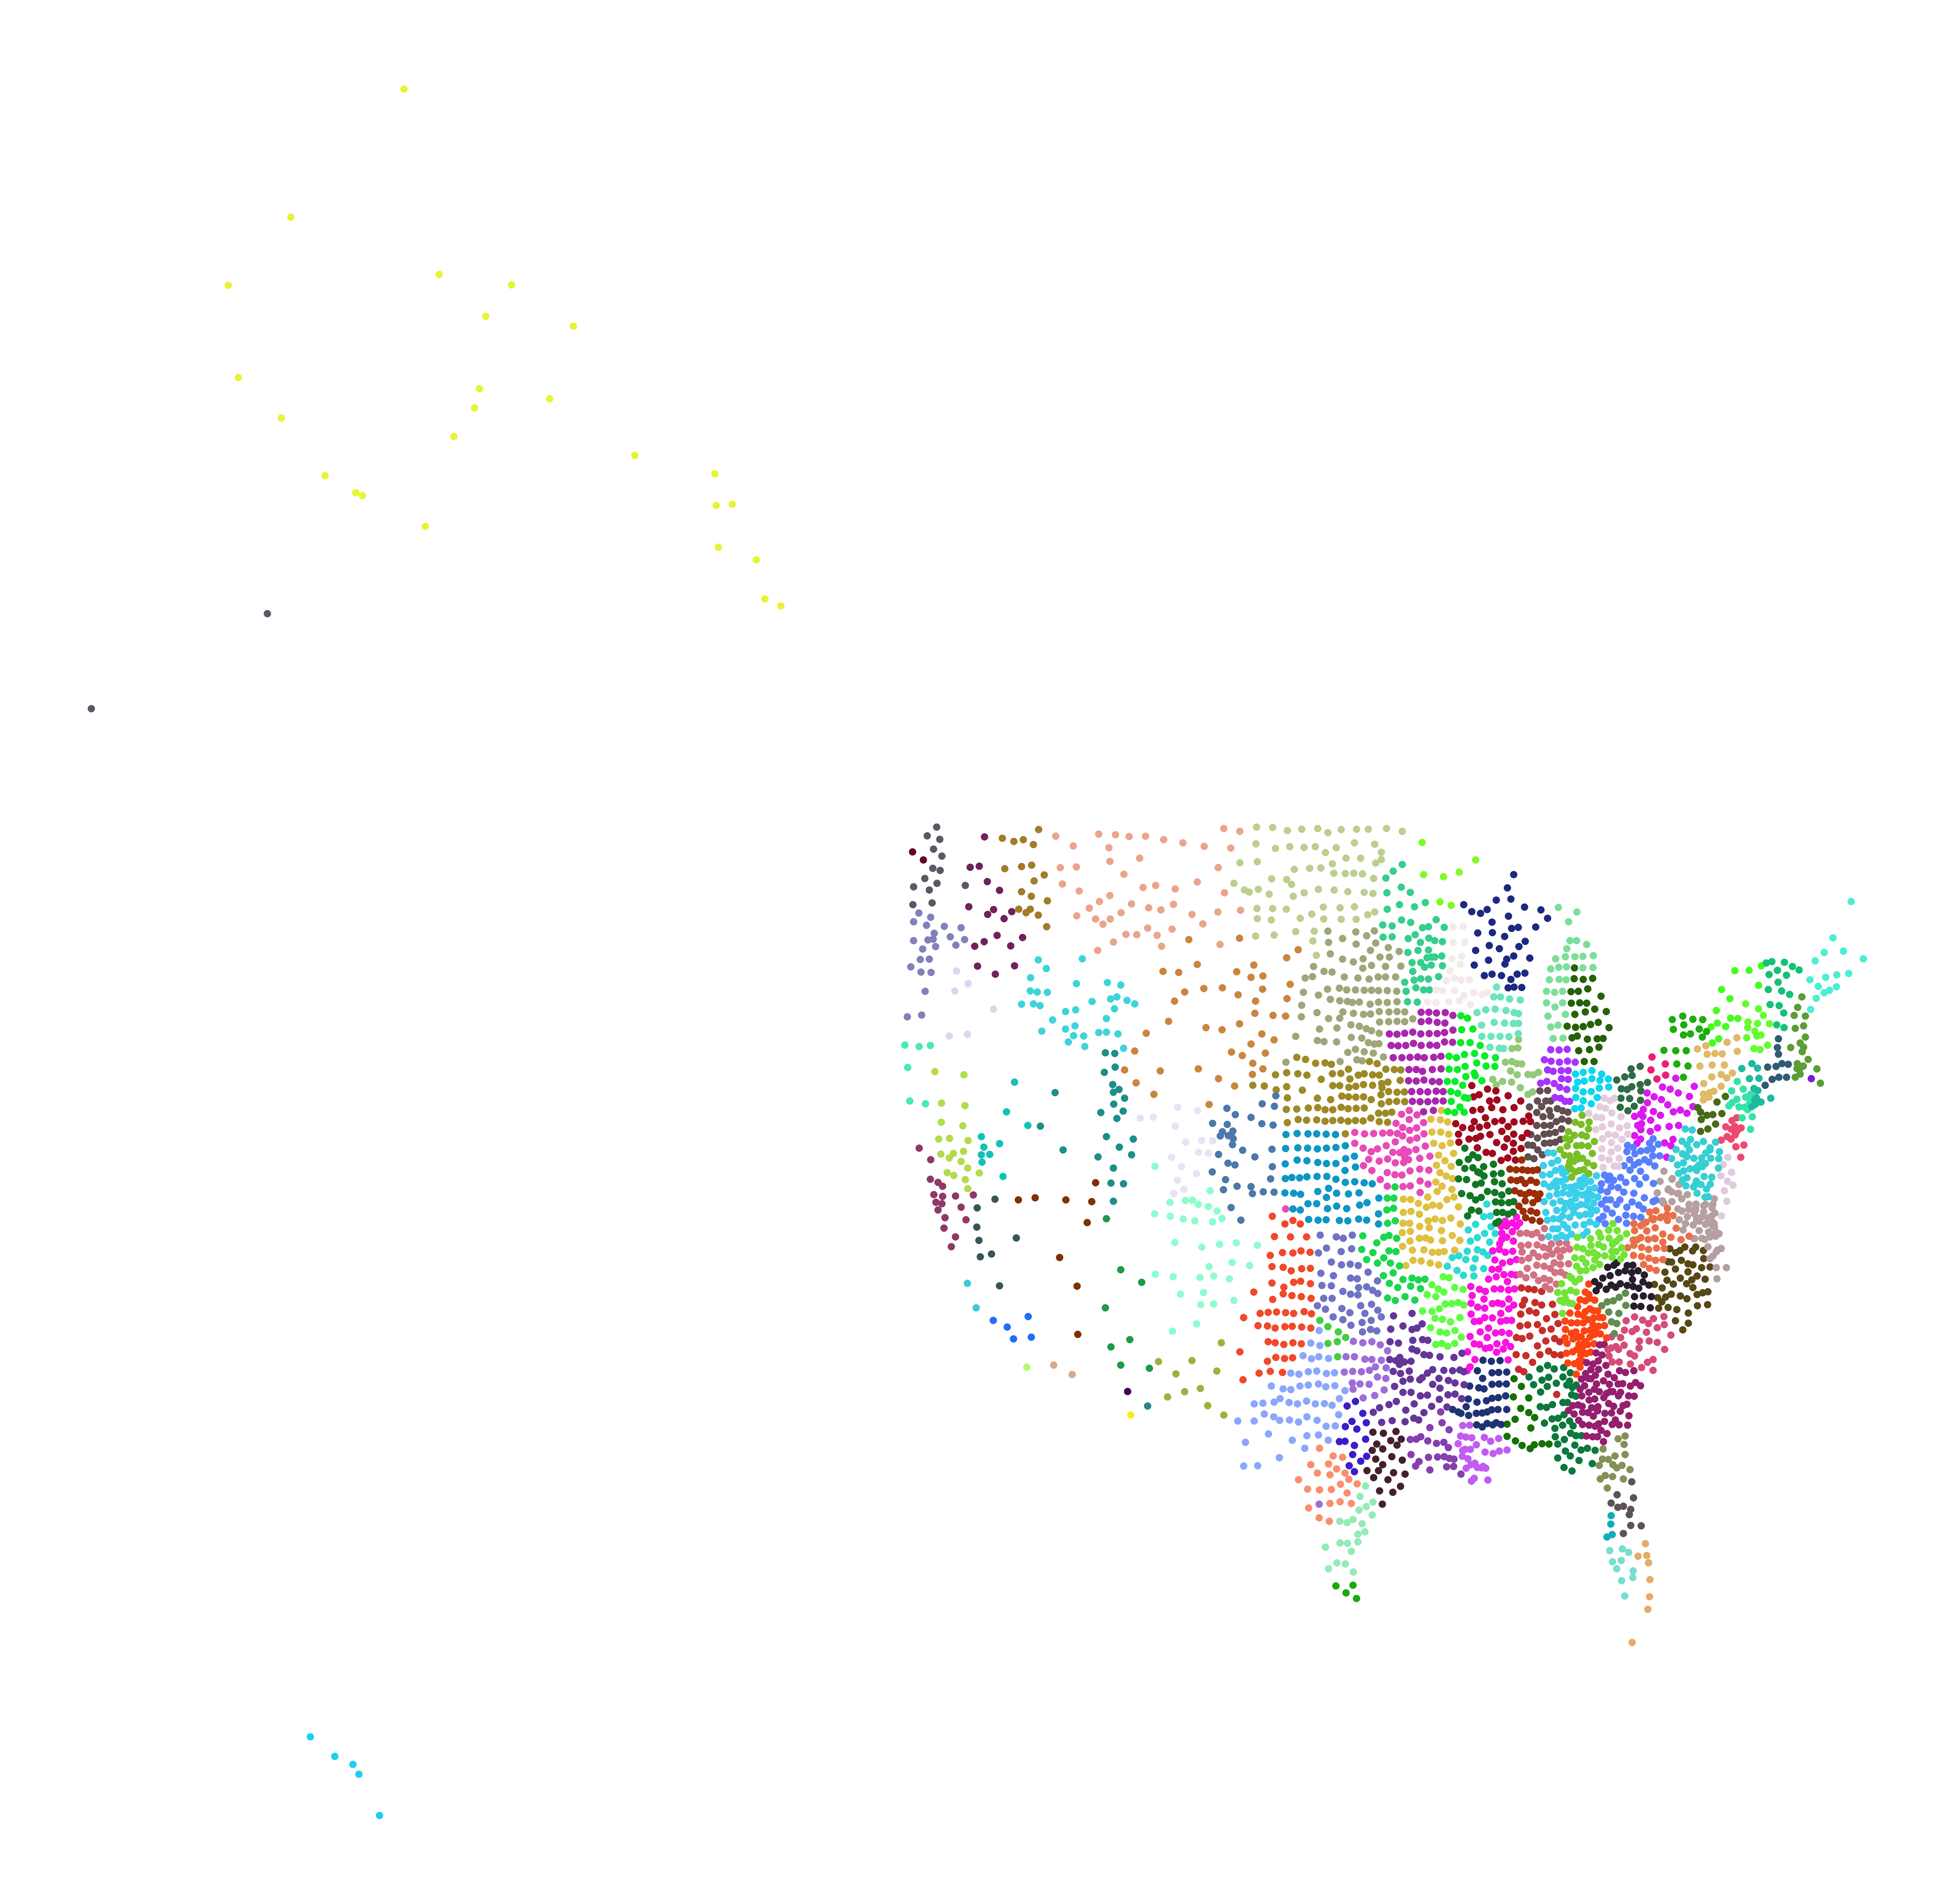

In [22]:
plt.figure(figsize=(100,100))
for i in range(0,len(CC)):
    color=(random.random(),random.random(),random.random())
    nx.draw_networkx_nodes(g,poss,nodelist=CC[i],node_size=400,node_color=color)           
plt.axis('off')